# Quantization Aware Training with NNCF, using TensorFlow framework

The goal of this notebook to demonstrate how to use the Neural Network Compression Framework [NNCF](https://github.com/openvinotoolkit/nncf) 8-bit quantization to optimize a TensorFlow model for inference with OpenVINO Toolkit. The optimization process contains the following steps:
* Fine-tuning of FP32 model
* Transform the original FP32 model to INT8
* Use fine-tuning to restore the accuracy
* Export optimized and original models to Frozen Graph and then to OpenVINO
* Measure and compare the performance of models

For more advanced usage, please refer to these [examples](https://github.com/openvinotoolkit/nncf/tree/develop/examples).

We selected the ResNet-50 model with Imagenette dataset. Imagenette is a subset of 10 easily classified classes from the Imagenet dataset. Using the smaller model and dataset will speed up training and download time. To see other Keras models, visit [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications#functions) module.

## Imports and Settings

On Windows, add the required C++ directories to the system's path.

Import NNCF and all auxiliary packages from your Python* code.
Set a name for the model, input image size, used batch size, and the learning rate. Also define paths where Frozen Graph and OpenVINO IR versions of the models will be stored.

In [ ]:
# On Windows, add the directory that contains cl.exe to the PATH to enable PyTorch to find the
# required C++ tools. This code assumes that Visual Studio 2019 is installed in the default
# directory. If you have a different C++ compiler, please add the correct path to os.environ["PATH"]
# directly.

# Adding the path to os.environ["LIB"] is not always required - it depends on the system's configuration

import sys

if sys.platform == "win32":
    import distutils.command.build_ext
    import os
    from pathlib import Path

    VS_INSTALL_DIR = r"C:/Program Files (x86)/Microsoft Visual Studio"
    cl_paths = sorted(list(Path(VS_INSTALL_DIR).glob("**/Hostx86/x64/cl.exe")))
    if len(cl_paths) == 0:
        raise ValueError(
            "Cannot find Visual Studio. This notebook requires C++. If you installed "
            "a C++ compiler, please add the directory that contains cl.exe to "
            "`os.environ['PATH']`"
        )
    else:
        # If multiple versions of MSVC are installed, get the most recent version
        cl_path = cl_paths[-1]
        vs_dir = str(cl_path.parent)
        os.environ["PATH"] += f"{os.pathsep}{vs_dir}"
        # Code for finding the library dirs from
        # https://stackoverflow.com/questions/47423246/get-pythons-lib-path
        d = distutils.core.Distribution()
        b = distutils.command.build_ext.build_ext(d)
        b.finalize_options()
        os.environ["LIB"] = os.pathsep.join(b.library_dirs)
        print(f"Added {vs_dir} to PATH")

In [ ]:
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

from nncf import NNCFConfig
from nncf.tensorflow.helpers.model_creation import create_compressed_model
from nncf.tensorflow.initialization import register_default_init_args

OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(exist_ok=True)

BASE_MODEL_NAME = "ResNet-50"

fp32_pb_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".pb")
fp32_pb_name = Path(BASE_MODEL_NAME + "_fp32").with_suffix(".pb")
fp32_ir_path = fp32_pb_path.with_suffix(".xml")
int8_pb_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_int8")).with_suffix(".pb")
int8_pb_name = Path(BASE_MODEL_NAME + "_int8").with_suffix(".pb")
int8_ir_path = int8_pb_path.with_suffix(".xml")

BATCH_SIZE = 32
IMG_SIZE = (224, 224) # Imagenet image size
NUM_CLASSES = 10 # For Imagenette dataset

LR = 1e-5

## Dataset preprocessing

Download and prepare Imagenette 160px dataset.
- Number of classes: 10
- Download size: 94.18 MiB
| Split        | Examples |
|--------------|----------|
| 'train'      | 12,894   |
| 'validation' | 500      |

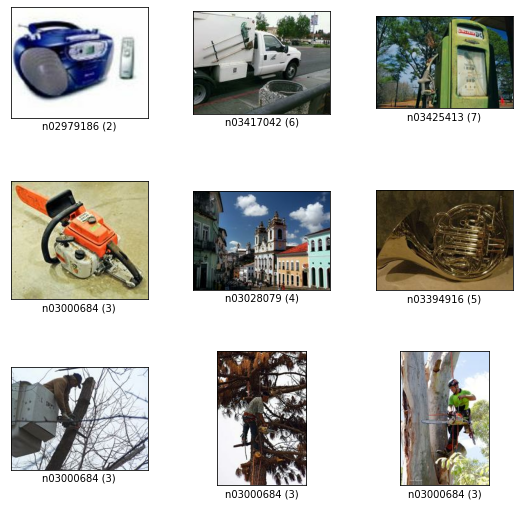

In [ ]:
datasets, datasets_info = tfds.load('imagenette/160px', as_supervised=True, with_info=True)
train_dataset, validation_dataset = datasets['train'], datasets['validation']
fig = tfds.show_examples(train_dataset, datasets_info)

In [ ]:
def train_preprocessing(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.2, 0.4)
    return image, label

def val_preprocessing(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

train_dataset = (train_dataset.map(train_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .shuffle(datasets_info.splits['train'].num_examples)
                              .batch(BATCH_SIZE)
                              .prefetch(tf.data.experimental.AUTOTUNE))

validation_dataset = (validation_dataset.map(val_preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                        .batch(BATCH_SIZE)
                                        .prefetch(tf.data.experimental.AUTOTUNE))

## Define a floating-point model

In [ ]:
# Create the base model from the MobileNet V3 Small model. The model is pretrained on ImageNet.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

# Add a classification head to meet the number of classes in the used dataset
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES)(x)
model = tf.keras.Model(base_model.input, outputs)

## Pre-train floating-point model

Using NNCF for model compression assumes that the user has a pre-trained model and a training pipeline.

Here we demonstrate one possible training pipeline: ResNet-50 model pre-trained on 1000 classes from ImageNet and fine-tuned with 10 classes from Imagenette.

Subsequently, the training and validation functions will be reused for quantization-aware training.

> **NOTE** The model is not tuned till the final accuracy. For the sake of simplicity of the tutorial, we tune for 4 epochs only and take the last model state for quantization.

In [ ]:
# Compile the floating-point model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the floating-point model
model.fit(train_dataset,
          epochs=4,
          validation_data=validation_dataset)

# Validate the floating-point model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of FP32 model: {test_acc:.3f}")

Save the floating-point model to the frozen graph, which will be later used for conversion to OpenVINO IR and further performance measurement.

In [ ]:
def export_model_to_frozen_graph(model, output_dir, model_name):
    # Convert Keras model to the frozen graph.
    input_signature = []
    for item in model.inputs:
        input_signature.append(tf.TensorSpec(item.shape, item.dtype, item.name))
    concrete_function = tf.function(model).get_concrete_function(input_signature)
    frozen_func = convert_variables_to_constants_v2(concrete_function, lower_control_flow=False)
    frozen_graph = frozen_func.graph.as_graph_def(add_shapes=True)
    
    tf.io.write_graph(frozen_graph, output_dir, model_name, as_text=False)

export_model_to_frozen_graph(model, OUTPUT_DIR, fp32_pb_name)

## Create and initialize quantization

NNCF enables compression-aware training by integrating into regular training pipelines. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires only 3 modifications.

1. Configure NNCF parameters to specify compression

In [ ]:
nncf_config_dict = {
    "input_info": {"sample_size": [1, 3] + list(IMG_SIZE)},
    "log_dir": str(OUTPUT_DIR),  # log directory for NNCF-specific logging outputs
    "compression": {
        "algorithm": "quantization",  # specify the algorithm here
        "initializer": {
            "batchnorm_adaptation": {
                "num_bn_adaptation_samples": 2048 # change the default number of samples for BatchNormalization adaptation
            }
        }
    },
}
nncf_config = NNCFConfig.from_dict(nncf_config_dict)

2. Provide data loader to initialize the values of quantization ranges and determine which activation should be signed or unsigned from the collected statistics using a given number of samples.

In [ ]:
nncf_config = register_default_init_args(nncf_config=nncf_config,
                                         data_loader=train_dataset,
                                         batch_size=BATCH_SIZE)

3. Create a wrapped model ready for compression fine-tuning from a pre-trained FP32 model and configuration object.

In [ ]:
compression_ctrl, model = create_compressed_model(model, nncf_config, None)

Evaluate the new model on the validation set after initialization of quantization. The accuracy should be not far from the accuracy of the floating-point FP32 model for a simple case like the one we are demonstrating now.

In [ ]:
# Compile the int8 model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Validate the int8 model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of INT8 model after initialization: {test_acc:.3f}")

## Fine-tune the compressed model

At this step, a regular fine-tuning process is applied to restore accuracy drop. Normally, several epochs of tuning are required with a small learning rate, the same that is usually used at the end of the training of the original model. No other changes in the training pipeline are required. Here is a simple example.

In [ ]:
# Train the int8 model
model.fit(train_dataset,
          epochs=2)

# Validate the int8 model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of INT8 model after fine-tuning: {test_acc:.3f}")

Save the INT8 model to the frozen graph, which will be later used for conversion to OpenVINO IR and further performance measurement.

In [ ]:
export_model_to_frozen_graph(model, OUTPUT_DIR, int8_pb_name)

## Export ONNX models to OpenVINO™ Intermediate Representation (IR)

Call the OpenVINO Model Optimizer tool to convert the Frozen Graph model to OpenVINO IR. The models are saved to the current directory.

See the [Model Optimizer Developer Guide](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information about Model Optimizer.

Executing this command may take a while. There may be some errors or warnings in the output. Model Optimization successfully export to IR if the last lines of the output include: `[ SUCCESS ] Generated IR version 10 model`

In [ ]:
if not fp32_ir_path.exists():
    !mo  --framework=tf --reverse_input_channels --input_shape=[1,224,224,3] --input=Placeholder --input_model=$fp32_pb_path --output_dir=$OUTPUT_DIR

In [ ]:
if not int8_ir_path.exists():
    !mo  --framework=tf --reverse_input_channels --input_shape=[1,224,224,3] --input=Placeholder --input_model=$int8_pb_path --output_dir=$OUTPUT_DIR

## Benchmark model performance by computing inference time

Finally, we will measure the inference performance of the FP32 and INT8 models. To do this, we use [Benchmark Tool](https://docs.openvinotoolkit.org/latest/openvino_inference_engine_tools_benchmark_tool_README.html) - OpenVINO's inference performance measurement tool. By default, Benchmark Tool runs inference for 60 seconds in asynchronous mode on CPU. It returns inference speed as latency (milliseconds per image) and throughput (frames per second) values.

> **NOTE**: In this notebook we run benchmark_app for 15 seconds to give a quick indication of performance. For more accurate performance, we recommended running benchmark_app in a terminal/command prompt after closing other applications. Run benchmark_app -m model.xml -d CPU to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run benchmark_app --help to see an overview of all command line options.

In [ ]:
def parse_benchmark_output(benchmark_output):
    parsed_output = [line for line in benchmark_output if not (line.startswith(r"[") or line.startswith("  ") or line=="")]
    print(*parsed_output, sep='\n')

print('Benchmark FP32 model (IR)')
benchmark_output = ! benchmark_app -m $fp32_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

print('\nBenchmark INT8 model (IR)')
benchmark_output = ! benchmark_app -m $int8_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

Show CPU Information for reference

In [ ]:
try:
    import cpuinfo

    print(cpuinfo.get_cpu_info()["brand_raw"])
except Exception:
    # OpenVINO installs cpuinfo, but if a different version is installed
    # the command above may not work
    print(platform.processor())